In [2]:
import json
import os
import csv
import rdflib
from rdflib import ConjunctiveGraph, Graph, URIRef, Literal, Namespace
from rdflib.namespace import SKOS, DCTERMS, RDF, RDFS, XSD

from openai import OpenAI
from langchain.chains import GraphSparqlQAChain
from langchain_community.graphs import RdfGraph
from langchain_openai import ChatOpenAI

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

import requests
import xml.etree.ElementTree as ET
from html.parser import HTMLParser
from html import unescape
import re
from keybert import KeyBERT

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
# Opening config file, the config structure is:
# {"access_token_zenodo":"......"
# "openai_api_key":"......"}

config = open('config', 'r')
config = json.load(config)

os.environ['OPENAI_API_KEY'] = config['openai_api_key']

In [4]:
# Load the JSON dataset
with open('dataset/text_RDF_gt.json', 'r') as file:
    data = json.load(file)

# Access the dataset
dataset = data['dataset']

In [5]:
def load_graph(data):
    g = rdflib.Graph()
    g.parse(data=data, format="turtle")
    return g

In [6]:
def print_rdf(rdf):
    g = rdflib.Graph()
    g.parse(data=rdf, format="turtle")

    for s, p, o in g:
        print(s, p, o)

In [20]:
# Namespaces
NS0 = Namespace("http://soilwise-he.github.io/soil-health#")
agrovoc = Namespace("http://aims.fao.org/aos/agrovoc/")
agrontology = Namespace("http://aims.fao.org/aos/agrontology#")
glosis_lh = Namespace("http://w3id.org/glosis/model/layerhorizon/")

In [162]:
with open('report/soil_report.json', 'r') as file:
    report = json.load(file)

print(report[130]['text'])

Specific monitoring programmes are needed for organic soils and their associated depth of accrued organic matter. The programmes for SOC monitoring in mineral soils are useful, but they should aim to increase their spatial resolution at the EU level and include not only assessment of bulk density, texture and possibly fine fraction carbon (<20µm, MAOM) but also yield differences and information on past and current land use.


In [133]:
with open('report/references.json', 'r') as file:
    report = json.load(file)

print(report[39]['text'])

Becking, G. C., et al., 2007, 'Essential metals: assessing risks from deficiency and toxicity', in: Nordberg, G. F., et al. (eds), Handbook on the toxicology of metals , 3rd edition, Elsevier, San Diego, pp. 163-176.


### A simple example of converting text to RDF triples

In [166]:
# Corresponding ground-truth RDF statements
print(dataset[3]['rdf_graph_turtle'])

@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .

agrovoc:c_a9645d28 a skos:Concept;
    skos:prefLabel "Soil Quality";
    skos:scopeNote "The inherent capacity which provides the basic frame within which a soil evolves.";
    dc:source ns0:Bonfante2020, ns0:Vogel2020.

ns0:SoilHealth a skos:Concept;
    skos:prefLabel "Soil Health";
    skos:scopeNote "The actual capacity of a soil to perform its core functions and to provide ecosystem services.";
    skos:closeMatch agrovoc:c_a9645d28;
    dc:source ns0:Bonfante2020, ns0:Vogel2020.

ns0:SoilPotential a skos:Concept;
    skos:prefLabel "Soil Potential";
    skos:definition "The maximum functionality a soil can offer based on its inherent properties.";
    skos:related agrovoc:c_a9645d28;
    agrontology:isInfluence

In [177]:
# Raw texts from the report
print(dataset[3]['text'])

A differentiation between soil health and soil quality was supported by Bonfante et al. (2020) and Vogel et al (2020). They define soil health as the actual capacity of a soil to perform its core functions and to provide ecosystem services, and soil quality as the inherent capacity which provides the basic frame within which a soil evolves. Vogel et al. (2020) also define intrinsic 'soil potential' as the maximum functionality a soil can offer based on its inherent properties. This entails an optimum state (condition) of soil based on sustainable management (best use of its properties). This is the basis for a third dimension of soil quality:
3.	the dynamic element of soil quality, which characterises the actual state of soils and is based on sensitive (responsive), manageable soil attributes.


In [167]:
rdf = """@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .

agrovoc:c_a9645d28 a skos:Concept;
    skos:prefLabel "soil quality";
    skos:scopeNote "The inherent capacity which provides the basic frame within which a soil evolves.";
    dc:source ns0:Bonfante2020, ns0:Vogel2020.

ns0:SoilHealth a skos:Concept;
    skos:prefLabel "soil health";
    skos:scopeNote "The actual capacity of a soil to perform its core functions and to provide ecosystem services.";
    skos:closeMatch agrovoc:c_a9645d28;
    dc:source ns0:Bonfante2020, ns0:Vogel2020.

agrovoc:c_7156 a skos:Concept;
    skos:prefLabel "soil";
    agrontology:performs agrovoc:c_e5629cbd;
    agrontology:isSourceOf agrovoc:c_1348040570280.

agrovoc:c_e5629cbd a skos:Concept;
    skos:prefLabel "soil functions".

agrovoc:c_1348040570280 a skos:Concept;
    skos:prefLabel "ecosystem services".

ns0:SoilPotential a skos:Concept;
    skos:prefLabel "soil potential";
    skos:definition "The maximum functionality a soil can offer based on its inherent properties.";
    skos:related agrovoc:c_a9645d28;
    agrontology:isInfluencedBy ns0:SoilState;
    dc:source ns0:Vogel2020.

ns0:SoilState a skos:Concept;
    skos:prefLabel "soil state";
    skos:altLabel "soil condition";
    skos:related agrovoc:c_a9645d28;
    agrontology:isAffectedBy agrovoc:c_7176.

ns0:SoilAttributes a skos:Concept;
    skos:prefLabel "soil attributes";
    skos:related agrovoc:c_a9645d28.

agrovoc:c_7176 a skos:Concept;
    skos:prefLabel "soil management".

ns0:Bonfante2020 a dc:BibliographicResource;
    dc:date "2020".

ns0:Vogel2020 a dc:BibliographicResource;
    dc:date "2020"."""

In [168]:
print(json.dumps(rdf))

"@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n@prefix dc: <http://purl.org/dc/terms/> .\n@prefix ns0: <http://soilwise-he.github.io/soil-health#> .\n@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .\n@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .\n\nagrovoc:c_a9645d28 a skos:Concept;\n    skos:prefLabel \"soil quality\";\n    skos:scopeNote \"The inherent capacity which provides the basic frame within which a soil evolves.\";\n    dc:source ns0:Bonfante2020, ns0:Vogel2020.\n\nns0:SoilHealth a skos:Concept;\n    skos:prefLabel \"soil health\";\n    skos:scopeNote \"The actual capacity of a soil to perform its core functions and to provide ecosystem services.\";\n    skos:closeMatch agrovoc:c_a9645d28;\n    dc:source ns0:Bonfante2020, ns0:Vogel2020.\n\nagrovoc:c_7156 a skos:Concept;\n    skos:prefLabel \"soil\";\n    agrontology:performs agrovoc:c_e5629cbd;\n    agrontology:isSourceOf agrovoc:c_1348040570280.\n\nagrovoc:c_e5629cbd a skos:Concept;\n    skos:p

In [169]:
print_rdf(rdf)

http://aims.fao.org/aos/agrovoc/c_a9645d28 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://aims.fao.org/aos/agrovoc/c_a9645d28 http://www.w3.org/2004/02/skos/core#scopeNote The inherent capacity which provides the basic frame within which a soil evolves.
http://aims.fao.org/aos/agrovoc/c_e5629cbd http://www.w3.org/2004/02/skos/core#prefLabel soil functions
http://soilwise-he.github.io/soil-health#SoilAttributes http://www.w3.org/2004/02/skos/core#prefLabel soil attributes
http://soilwise-he.github.io/soil-health#Bonfante2020 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://purl.org/dc/terms/BibliographicResource
http://soilwise-he.github.io/soil-health#SoilPotential http://www.w3.org/2004/02/skos/core#related http://aims.fao.org/aos/agrovoc/c_a9645d28
http://soilwise-he.github.io/soil-health#SoilPotential http://purl.org/dc/terms/source http://soilwise-he.github.io/soil-health#Vogel2020
http://aims.fao.org/aos/agrovoc/c_a9645d28 

In [170]:
g = load_graph(dataset[0]['rdf_graph_turtle'])

In [171]:
print_rdf(dataset[0]['rdf_graph_turtle'])

http://aims.fao.org/aos/agrovoc/c_e5629cbd http://www.w3.org/2004/02/skos/core#prefLabel Soil Functions
http://aims.fao.org/aos/agrovoc/c_49904 http://www.w3.org/2004/02/skos/core#prefLabel Organisms
http://aims.fao.org/aos/agrovoc/c_5384 http://www.w3.org/2004/02/skos/core#prefLabel Organic Compounds
http://soilwise-he.github.io/soil-health/YoungCrawford2004 http://purl.org/dc/terms/date 2004
http://soilwise-he.github.io/soil-health/Biomaterials http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://aims.fao.org/aos/agrovoc/c_7156 http://www.w3.org/2004/02/skos/core#prefLabel Soil
http://soilwise-he.github.io/soil-health/Biomaterials http://www.w3.org/2004/02/skos/core#prefLabel Biomaterials
http://soilwise-he.github.io/soil-health/SoilVariability http://www.w3.org/2004/02/skos/core#prefLabel Soil Variability
http://aims.fao.org/aos/agrovoc/c_e5629cbd http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept


(process:26412): Pango-WARNING **: 14:17:01.187: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:26412): Pango-WARNING **: 14:17:01.204: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:26412): Pango-WARNING **: 14:17:01.213: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



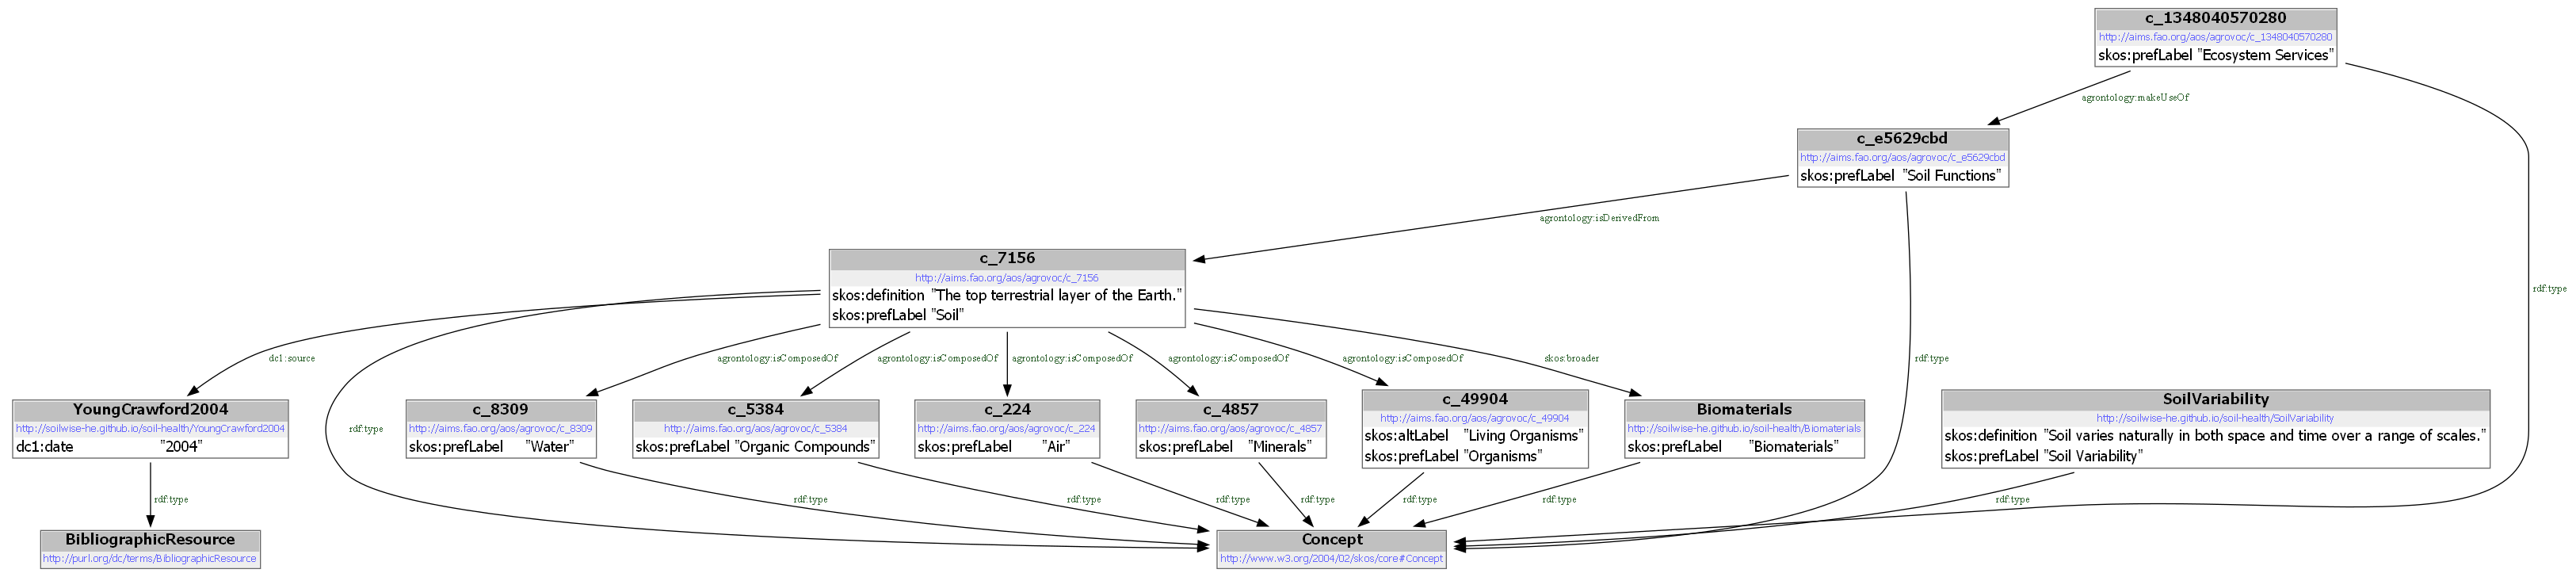

In [172]:
# Visualize the graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

### Convert text to RDF triples with LLMs: a zero-shot example

In [173]:
# System prompt for zero-shot learning
system_prompt_0 = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not customize classes**.
  - When you identify a subject as a concept related to soil science and soil health, always use `'skos:Concept'` to label it.
  - If a subject is not a concept, please search for a class from an extant ontology or vocabulary to label it.
- **Include Preferred Labels**:
  - For every concept and entity, include a `skos:prefLabel` with the human-readable name in lowercase found in the text.
- **URIs**: URIs should be names or human-readable identifiers derived from the text. Use `ns0: <http://soilwise-he.github.io/soil-health#>` as prefix. Split words in URIs by capitalizing initial letters.

## 4. Relations and Predicates
- **Relationships** represent connections between entities or concepts.
- Attempt to extract as many relations as you can.
- Ensure consistency and generality in relationship predicates when constructing knowledge graphs.
- Instead of using specific and momentary predicates, use more general and timeless relationship predicates.
- **Emphasize Generality**: Make sure to use general and timeless relationship predicates to enhance the universality and longevity of the knowledge graph.

## 5. Coreference Resolution
- **Maintain Entity/Concept Consistency**: When extracting entities and concepts, it's vital to ensure consistency.
- If an entity or concept is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier and preferred label for that entity or concept throughout the knowledge graph.

## 6. Objects
- **Retaining Text as Objects**: Do not retain the given text as objects, except in the following two cases:
  - **Definitions**: If the text is defining entities or concepts, include the full definition as an object and use `'skos:definition'` as the predicate.
  - **Differences or Distinctions**: If the text is discussing the differences or distinctions between concepts or entities, capture these differences by creating explanatory notes using `'skos:scopeNote'` as the predicate.
- **Important**: Even when you retain parts of the text as objects (definitions or scope notes), you must still extract entities, relationships, and references according to the previous instructions.

## 7. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dc`) to label references.
  - Represent each reference as a `dc:BibliographicResource`.
- **Connecting Information to References**:
  - Use `dc:source` to indicate which information in the text references this literature.
  - When an extracted piece of information is supported by a reference, link it to the corresponding `dc:BibliographicResource` using `dc:source`.

## 8. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination."""

print(system_prompt_0)

# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocab

In [174]:
prompt_0 = f"""
Please help me convert this text to an RDF knowledge graph:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!
"""

In [176]:
client = OpenAI()

completion = client.chat.completions.create(
    model="chatgpt-4o-latest",
    messages=[
        {"role": "system", "content": system_prompt_0},
        {
            "role": "user",
            "content": prompt_0
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix ns0: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .

ns0:SustainableSoilManagement a skos:Concept ;
    skos:prefLabel "sustainable soil management" .

ns0:SoilProtection a skos:Concept ;
    skos:prefLabel "soil protection" .

ns0:SoilKnowledge a skos:Concept ;
    skos:prefLabel "soil knowledge" .

ns0:SoilHealth a skos:Concept ;
    skos:prefLabel "soil health" .

ns0:EcosystemServices a skos:Concept ;
    skos:prefLabel "ecosystem services" .

ns0:LandCultivation a skos:Concept ;
    skos:prefLabel "land cultivation" .

ns0:Urbanisation a skos:Concept ;
    skos:prefLabel "urbanisation" .

ns0:SoilAlteration a skos:Concept ;
    skos:prefLabel "soil alteration" .

ns0:SoilDegradation a skos:Concept ;
    skos:prefLabel "soil degradation" .

ns0:SoilFunctioning a skos:Concept ;
    skos:prefLabel "soil functioning" .

ns0:DegradedSoil a skos:Concept ;
    skos:pre

In [178]:
rdf_data_llm_0 = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_0 = rdf_data_llm_0.replace('\n```', '')

print_rdf(rdf_data_llm_0)
g_0 = load_graph(rdf_data_llm_0)

http://soilwise-he.github.io/soil-health#SustainableSoilManagement http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#SoilSealing http://soilwise-he.github.io/soil-health#leadsTo http://soilwise-he.github.io/soil-health#SoilFunctionLoss
http://soilwise-he.github.io/soil-health#LandCultivation http://purl.org/dc/elements/1.1/source http://soilwise-he.github.io/soil-health#RefEC2020a
http://soilwise-he.github.io/soil-health#RefJRC2012 http://purl.org/dc/elements/1.1/title JRC, 2012
http://soilwise-he.github.io/soil-health#LandCultivation http://soilwise-he.github.io/soil-health#causes http://soilwise-he.github.io/soil-health#SoilAlteration
http://soilwise-he.github.io/soil-health#SoilSealing http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#Ecosystems http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/s

In [179]:
from uk2us import uk_us

# Function to normalize British English to American English
def normalize_uk_to_us(label):
    for uk_spelling, us_spelling in uk_us:
        # Use regular expressions to replace only full words
        label = re.sub(rf'\b{uk_spelling}\b', us_spelling, label)
    return label

def concept2agrovoc(g):
    # Load the CSV file
    pref_label_map = {}
    alt_label_map = {}
    with open("ontovocabs/agrovoc.csv", encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            new_uri = row['Concept']
            pref_label = row['prefLabel'].lower()
            alt_labels = row['altLabel'].split(';') if row['altLabel'] else []
            pref_label_map[pref_label] = new_uri
            for alt_label in alt_labels:
                alt_label = alt_label.strip().lower()  # Clean and normalize altLabel
                if alt_label:
                    alt_label_map[alt_label] = new_uri

    # Iterate over the graph and process matching prefLabel and altLabel
    for s, p, o in g:
        label = str(o).lower()
        normalized_label = normalize_uk_to_us(label)  # Apply normalization

        if p == SKOS.prefLabel and normalized_label in pref_label_map:
            new_uri = rdflib.URIRef(pref_label_map[normalized_label])
            # Collect all triples with the old subject
            for s2, p2, o2 in g.triples((s, None, None)):
                if s2 != new_uri:
                    g.add((new_uri, p2, o2))
                    g.remove((s2, p2, o2))
            for s3, p3, o3 in g.triples((None, None, s)):
                if o3 != new_uri:
                    g.add((s3, p3, new_uri))
                    g.remove((s3, p3, o3))
        elif p == SKOS.prefLabel and normalized_label in alt_label_map:
            # Add skos:closeMatch triples
            close_match_uri = rdflib.URIRef(alt_label_map[normalized_label])
            g.add((s, SKOS.closeMatch, close_match_uri))

    g.bind("agrovoc", agrovoc)

    return g

# Example usage
g_0 = concept2agrovoc(g_0)

# Print the updated knowledge graph
print(g_0.serialize(format="turtle"))

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_8088 a skos:Concept ;
    dc:source ns0:RefEC2020a,
        ns0:RefJRC2012 ;
    ns0:causes ns0:SoilAlteration ;
    skos:prefLabel "urbanisation" .

agrovoc:c_f9554e7c a skos:Concept ;
    ns0:leadsTo ns0:SoilFunctionLoss ;
    skos:prefLabel "soil sealing" ;
    skos:scopeNote "soil functions are largely and irreversibly lost due to soil sealing" .

ns0:DegradedSoil a skos:Concept ;
    skos:prefLabel "degraded soil" .

ns0:LandCultivation a skos:Concept ;
    dc:source ns0:RefEC2020a,
        ns0:RefJRC2012 ;
    ns0:causes ns0:SoilAlteration ;
    skos:prefLabel "land cultivation" .

ns0:SoilFunctioning a skos:Concept ;
    skos:prefLabel "soil functioning" .

ns0:SoilHealth a skos:Concept ;
    ns0:delivers agrovoc:c_1348040570280 ;
    skos:closeMatch agro

In [180]:
# Load the valid agrontology terms from the CSV file
def load_agrontology_terms(csv_file_path):
    agrontology_terms = []
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            prop = row['prop'].strip()
            label = row['label'].strip()
            agrontology_terms.append({
                'prop': prop,
                'label': label
            })
    return agrontology_terms

# Generate embeddings using OpenAI API
def get_embedding(text):
    response = client.embeddings.create(
    model="text-embedding-3-large",
    input=text
    )
    return np.array(response.data[0].embedding)

# Precompute embeddings for valid agrontology terms using only label
def embed_valid_terms(valid_terms):
    embeddings = {}
    for term in valid_terms:
        text_to_embed = term['label']
        embeddings[term['prop']] = get_embedding(text_to_embed)
    return embeddings

# Compare custom terms to valid terms using cosine similarity with precomputed embeddings
def find_closest_term(custom_term, valid_terms, valid_embeddings):
    custom_embedding = get_embedding(custom_term)
    valid_term_list = [term['prop'] for term in valid_terms]
    valid_embeddings_list = [valid_embeddings[term] for term in valid_term_list]
    
    similarities = cosine_similarity([custom_embedding], valid_embeddings_list)[0]
    best_match_index = np.argmax(similarities)
    
    return valid_term_list[best_match_index], similarities[best_match_index]

# Main function to check and correct the RDF knowledge graph
def check_and_correct_rdf(rdf_string, csv_file_path):
    # Step 1: Load valid agrontology terms
    agrontology_terms = load_agrontology_terms(csv_file_path)
    valid_props = [term['prop'] for term in agrontology_terms]

    # Step 2: Precompute embeddings for valid agrontology terms
    valid_term_embeddings = embed_valid_terms(agrontology_terms)
    
    # Step 3: Extract predicates from RDF graph
    graph = rdflib.Graph()
    graph.parse(data=rdf_string, format="turtle")
    
    # Step 4: Iterate over all predicates and check if they are valid
    for s, pred, o in graph:
        pred_str = str(pred)
        if pred_str.startswith("http://soilwise-he.github.io/soil-health#"):
            predicate_short = pred_str.split("#")[-1]  # Get the short version of the predicate
            if predicate_short not in agrontology_terms:
                # If the term is not found, find the closest valid term
                closest_term, similarity = find_closest_term(predicate_short, agrontology_terms, valid_term_embeddings)
                print(similarity)
                if similarity > 0.5:  # Threshold for correction
                    # Replace the wrong predicate with the closest valid term
                    new_predicate_uri = f"http://aims.fao.org/aos/agrontology#{closest_term}"
                    graph.set((s, rdflib.URIRef(new_predicate_uri), o))
                    graph.remove((s, pred, o))
                else:
                    graph.remove((s, pred, o))
            else:
                new_predicate_uri = f"http://aims.fao.org/aos/agrontology#{predicate_short}"
                graph.set((s, rdflib.URIRef(new_predicate_uri), o))
                graph.remove((s, pred, o))
    
    # Step 5: Output the corrected RDF triples
    corrected_rdf_turtle = graph.serialize(format="turtle")
    
    return corrected_rdf_turtle

corrected_rdf_turtle = check_and_correct_rdf(g_0.serialize(format="turtle"), 'ontovocabs/agrontology.csv')

g_0 = load_graph(corrected_rdf_turtle)
print(g_0.serialize(format="turtle"))

0.48134814771998635
0.3992022958229059
0.8232006786012459
0.4781353824167552
0.3852732545244328
0.3969524224713406
0.8232542049139524
0.8987620552792024
0.3992022958229059
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health#> .
@prefix ns1: <http://aims.fao.org/aos/agrontology#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_1348040570280 a skos:Concept ;
    skos:prefLabel "ecosystem services" .

agrovoc:c_2482 a skos:Concept ;
    skos:prefLabel "ecosystems" .

agrovoc:c_7168 a skos:Concept ;
    ns1:affects ns0:LifeSupportFunctions ;
    skos:prefLabel "soil degradation" .

agrovoc:c_8088 a skos:Concept ;
    ns1:causes ns0:SoilAlteration ;
    dc:source ns0:RefEC2020a,
        ns0:RefJRC2012 ;
    skos:prefLabel "urbanisation" .

agrovoc:c_f9554e7c a skos:Concept ;
    skos:prefLabel "soil sealing" ;
    skos:scopeNote "soil functions are largely and irreve

### A prompt engineering example

In [ ]:
system_prompt_engi = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, and references from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities relevant to **soil science and soil health**.
- Attempt to extract as many entities as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not customize classes**.
  - When you identify a subject as a concept related to soil science and soil health, always use `'skos:Concept'` to label it.
  - If a subject is not a concept, please search for a class from an extant ontology or vocabulary to label it.
- **Include Preferred Labels**:
  - For every entity, include a `skos:prefLabel` with the human-readable name found in the text.
- **URIs**: URIs should be names or human-readable identifiers found in the text.
- For example, the entity `'soil health'` should have the URI `'ns0:SoilHealth'` and include `skos:prefLabel 'soil health'`, where the prefix `ns0: <http://soilwise-he.github.io/soil-health#>`.

## 4. Relations and Predicates
- **Relationships** represent connections between entities.
- Attempt to extract as many relations as you can.
- Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. **Make sure to use general and timeless relationship predicates.**
- For example, the relationship extracted from the text `'Soil provides multiple functions'` should be that soil `'isSourceOf'` soil functions, rather than that soil `'provides'` soil functions.

## 5. Coreference Resolution
- **Maintain Entity Consistency**: When extracting entities, it's vital to ensure consistency.
- If an entity, such as `'soil functions'`, is mentioned multiple times in the text but is referred to by different forms (e.g., `'soil function'`, `'functions of soil'`), always use the most complete identifier for that entity throughout the knowledge graph. In this example, use `'soil functions'` as the entity label.
- Remember, the knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.

## 6. Objects
- Please do not retain the given text as objects, except in the following two cases:
  - If the text is defining entities: include the full definition as an object and use `'skos:definition'` as the predicate.
  - If the text is discussing the difference between entities: keep the differentiations and distinctions between them as separate objects and use `'skos:scopeNote'` as the predicate.
- **Important**: Even when you retain parts of the text as objects (definitions or scope notes), you must still extract entities, relationships, and references according to the previous instructions.

## 7. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dc`) to label references.
  - Represent each reference as a `dc:BibliographicResource`.
  - For example, a reference like `(Alice and Bob, 2024)` should be represented as: `ns0:AliceBob2024 a dc:BibliographicResource;`. `James et al. (2018)` should be `ns0:James2018` and `(ABC, 2014a)` should be `ns0:ABC2014a`.
- **Connecting Entities to References**:
  - When an extracted entity is supported by a reference, link it to the corresponding `dc:BibliographicResource` using `dc:source`.

## 8. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination."""

print(system_prompt_engi)

# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, and references from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities relevant to **soil science and soil health**.
- Attempt to extract as many entities as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not c

In [ ]:
prompt_0 = f"""
Please help me convert this text to an RDF knowledge graph:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!
"""

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
    model="chatgpt-4o-latest",
    messages=[
        {"role": "system", "content": system_prompt_engi},
        {
            "role": "user",
            "content": prompt_0
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix ns0: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .

ns0:SustainableSoilManagement a skos:Concept ;
    skos:prefLabel "sustainable soil management" .

ns0:Soil a skos:Concept ;
    skos:prefLabel "soil" ;
    skos:definition "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions." ;
    ns0:requires ns0:SoilKnowledge ;
    ns0:provides ns0:EcosystemServices .

ns0:SoilKnowledge a skos:Concept ;
    skos:prefLabel "soil knowledge" .

ns0:ClimateChange a skos:Concept ;
    skos:prefLabel "climatic conditions" .

ns0:HealthySoils a skos:Concept ;
    skos:prefLabel "healthy soils" ;
    ns0:provides ns0:EcosystemServices .

ns0:EcosystemServices a skos:Concept ;
    skos:prefLabel "ecosystem services" .

ns0:LandCultivation a skos:Concept ;
    skos:prefLabel "land cultivation" ;
    ns0:alters ns0:S

In [ ]:
rdf_data_llm_p = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_p = rdf_data_llm_p.replace('\n```', '')

print_rdf(rdf_data_llm_p)
g_p = load_graph(rdf_data_llm_p)

http://soilwise-he.github.io/soil-health#SustainableSoilManagement http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#HealthySoils http://www.w3.org/2004/02/skos/core#prefLabel healthy soils
http://soilwise-he.github.io/soil-health#LandCultivation http://soilwise-he.github.io/soil-health#alters http://soilwise-he.github.io/soil-health#SoilProperties
http://soilwise-he.github.io/soil-health#SoilProperties http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#LandCultivation http://purl.org/dc/elements/1.1/source http://soilwise-he.github.io/soil-health#EC2020a
http://soilwise-he.github.io/soil-health#ClimateChange http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#SoilFunctions http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/

In [ ]:
g_p = concept2agrovoc(g_p)

# Print the updated knowledge graph
print(g_p.serialize(format="turtle"))

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_7156 a skos:Concept ;
    ns0:provides agrovoc:c_1348040570280 ;
    ns0:requires ns0:SoilKnowledge ;
    skos:definition "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions." ;
    skos:prefLabel "soil" .

agrovoc:c_8088 a skos:Concept ;
    dc:source ns0:EC2020a,
        ns0:JRC2012 ;
    ns0:alters agrovoc:c_330883 ;
    skos:prefLabel "urbanisation" .

agrovoc:c_f9554e7c a skos:Concept ;
    ns0:destroys agrovoc:c_e5629cbd ;
    skos:prefLabel "soil sealing" ;
    skos:scopeNote "In the case of soil sealing, soil functions are largely and irreversibly lost." .

ns0:ClimateChange a skos:Concept ;
    skos:prefLabel "climatic conditions" .

ns0:DegradedSoils a skos:Concept ;
    ns0:hinde

In [ ]:
corrected_rdf_turtle = check_and_correct_rdf(g_p.serialize(format="turtle"), 'ontovocabs/agrontology.csv')

g_p = load_graph(corrected_rdf_turtle)
print(g_p.serialize(format="turtle"))

0.3904364445153896
0.44472102644589573
0.3559498808753251
0.4104690955104946
0.4104690955104946
0.3558373305786142
0.37411283370292087
0.2786708691188602
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_1348040570280 a skos:Concept ;
    skos:prefLabel "ecosystem services" .

agrovoc:c_2482 a skos:Concept ;
    skos:definition "Life support functions of ecosystems are harmed when soils are degraded." ;
    skos:prefLabel "ecosystems" .

agrovoc:c_330883 a skos:Concept ;
    skos:prefLabel "soil properties" .

agrovoc:c_7156 a skos:Concept ;
    skos:definition "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions." ;
    skos:prefLabel "soil" .

agrovoc:c_8088 a skos:Concept ;
    dc:source ns0:EC2020a,
        ns0:JRC2012 ;
    skos:prefLa


(process:4076): Pango-WARNING **: 12:22:36.364: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:4076): Pango-WARNING **: 12:22:36.377: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:4076): Pango-WARNING **: 12:22:36.380: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



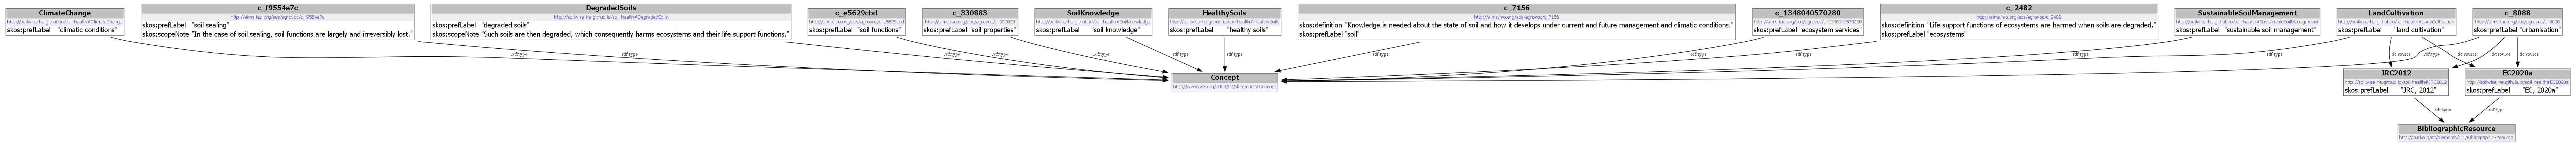

In [ ]:
visualize(g_p)

### A few-shot (one-shot) example

In [181]:
# Prompt for one-shot learning
prompt_1 = f"""
Now I will show an example of how to convert text to an RDF knowledge graph. Here is the raw text:
'{dataset[0]['text']}'
This is the ground-truth RDF knowledge graph for this text:
'{dataset[0]['rdf_graph_turtle']}'
Follow this example, please help me convert the following text to an RDF knowledge graph:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph in Turtle format without any comments. Thank you!
"""

In [191]:
completion = client.chat.completions.create(
    model="chatgpt-4o-latest",
    messages=[
        {"role": "system", "content": system_prompt_0},
        {
            "role": "user",
            "content": prompt_1
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .

agrovoc:c_7156 a skos:Concept;
    skos:prefLabel "Soil" .

agrovoc:c_e5629cbd a skos:Concept;
    skos:prefLabel "Soil Functions";
    agrontology:isDerivedFrom agrovoc:c_7156.

agrovoc:c_1348040570280 a skos:Concept;
    skos:prefLabel "Ecosystem Services";
    agrontology:makeUseOf agrovoc:c_e5629cbd.

ns0:SustainableSoilManagement a skos:Concept;
    skos:prefLabel "Sustainable Soil Management" .

ns0:SoilsUnderManagement a skos:Concept;
    skos:prefLabel "Soils Under Management" ;
    skos:scopeNote "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions." .

ns0:HealthySoils a skos:Concept;
    skos:prefLabel "Healthy Soils" ;
    sk

In [192]:
rdf_data_llm_1 = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_1 = rdf_data_llm_1.replace('\n```', '') 

print_rdf(rdf_data_llm_1)
g_1 = load_graph(rdf_data_llm_1)

http://aims.fao.org/aos/agrovoc/c_e5629cbd http://www.w3.org/2004/02/skos/core#prefLabel Soil Functions
http://aims.fao.org/aos/agrovoc/c_7156 http://www.w3.org/2004/02/skos/core#prefLabel Soil
http://soilwise-he.github.io/soil-health/SoilsUnderManagement http://www.w3.org/2004/02/skos/core#scopeNote Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions.
http://soilwise-he.github.io/soil-health/DegradedSoils http://aims.fao.org/aos/agrontology#isResultOf http://soilwise-he.github.io/soil-health/SoilDegradation
http://soilwise-he.github.io/soil-health/JRC2012 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://purl.org/dc/terms/BibliographicResource
http://aims.fao.org/aos/agrovoc/c_e5629cbd http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health/EC2020a http://purl.org/dc/terms/date 2020
http://soilwise-he.github.io/soil-health/SoilDegrad

In [193]:
g_1 = concept2agrovoc(g_1)

# Print the updated knowledge graph
print(g_1.serialize(format="turtle"))

@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc1: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_1348040570280 a skos:Concept ;
    agrontology:makeUseOf agrovoc:c_e5629cbd ;
    skos:prefLabel "Ecosystem Services" .

agrovoc:c_f9554e7c a skos:Concept ;
    agrontology:impair agrovoc:c_e5629cbd ;
    skos:definition "In the case of soil sealing, soil functions are largely and irreversibly lost." ;
    skos:prefLabel "Soil Sealing" .

ns0:DegradedSoils a skos:Concept ;
    agrontology:impair agrovoc:c_e5629cbd ;
    agrontology:isResultOf agrovoc:c_7168 ;
    skos:prefLabel "Degraded Soils" ;
    skos:scopeNote "Degraded soils harm ecosystems and their life support functions." .

ns0:HealthySoils a skos:Concept ;
    skos:definition "Healthy soils deliver ecosystem services to the best of their capacity

In [194]:
# Load the valid agrontology terms from the CSV file
def load_agrontology_terms(csv_file_path):
    agrontology_terms = []
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            prop = row['prop'].strip()
            label = row['label'].strip()
            agrontology_terms.append({
                'prop': prop,
                'label': label
            })
    return agrontology_terms

# Generate embeddings using OpenAI API
def get_embedding(text):
    response = client.embeddings.create(
    model="text-embedding-3-large",
    input=text
    )
    return np.array(response.data[0].embedding)

# Precompute embeddings for valid agrontology terms using only label
def embed_valid_terms(valid_terms):
    embeddings = {}
    for term in valid_terms:
        text_to_embed = term['label']
        embeddings[term['prop']] = get_embedding(text_to_embed)
    return embeddings

# Compare custom terms to valid terms using cosine similarity with precomputed embeddings
def find_closest_term(custom_term, valid_terms, valid_embeddings):
    custom_embedding = get_embedding(custom_term)
    valid_term_list = [term['prop'] for term in valid_terms]
    valid_embeddings_list = [valid_embeddings[term] for term in valid_term_list]
    
    similarities = cosine_similarity([custom_embedding], valid_embeddings_list)[0]
    best_match_index = np.argmax(similarities)
    
    return valid_term_list[best_match_index], similarities[best_match_index]

# Main function to check and correct the RDF knowledge graph
def check_and_correct_rdf(rdf_string, csv_file_path):
    # Step 1: Load valid agrontology terms
    agrontology_terms = load_agrontology_terms(csv_file_path)
    valid_props = [term['prop'] for term in agrontology_terms]

    # Step 2: Precompute embeddings for valid agrontology terms
    valid_term_embeddings = embed_valid_terms(agrontology_terms)
    
    # Step 3: Extract predicates from RDF graph
    graph = rdflib.Graph()
    graph.parse(data=rdf_string, format="turtle")
    
    # Step 4: Iterate over all predicates and check if they are valid
    for s, pred, o in graph:
        pred_str = str(pred)
        if pred_str.startswith("http://aims.fao.org/aos/agrontology#"):
            predicate_short = pred_str.split("#")[-1]  # Get the short version of the predicate
            if predicate_short not in agrontology_terms:
                # If the term is not found, find the closest valid term
                closest_term, similarity = find_closest_term(predicate_short, agrontology_terms, valid_term_embeddings)
                print(similarity)
                if similarity > 0.5:  # Threshold for correction
                    # Replace the wrong predicate with the closest valid term
                    new_predicate_uri = f"http://aims.fao.org/aos/agrontology#{closest_term}"
                    graph.set((s, rdflib.URIRef(new_predicate_uri), o))
                    graph.remove((s, pred, o))
                else:
                    graph.remove((s, pred, o))
    
    # Step 5: Output the corrected RDF triples
    corrected_rdf_turtle = graph.serialize(format="turtle")
    
    return corrected_rdf_turtle

corrected_rdf_turtle = check_and_correct_rdf(g_1.serialize(format="turtle"), 'ontovocabs/agrontology.csv')

g_1 = load_graph(corrected_rdf_turtle)
print(g_1.serialize(format="turtle"))

0.38646442297760486
0.7218566335591101
0.4583777655480785
0.4583777655480785
0.7433458179571348
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc1: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_1348040570280 a skos:Concept ;
    skos:prefLabel "Ecosystem Services" .

agrovoc:c_7156 a skos:Concept ;
    skos:prefLabel "Soil" .

agrovoc:c_7168 a skos:Concept ;
    dc1:source ns0:EC2020a,
        ns0:JRC2012 ;
    skos:definition "Land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning." ;
    skos:prefLabel "Soil Degradation" .

agrovoc:c_e5629cbd a skos:Concept ;
    skos:prefLabel "Soil Functions" .

agrovoc:c_f9554e7c a skos:Concept ;
    skos:definition "In the case of soil sealing, soil functions are largely and irreversibly lost." ;
    skos:prefLabel "Soil Sealing" .

ns0:DegradedSoils a skos:Concept ;
    skos:pr


(process:11340): Pango-WARNING **: 12:26:01.554: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:11340): Pango-WARNING **: 12:26:01.564: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:11340): Pango-WARNING **: 12:26:01.570: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



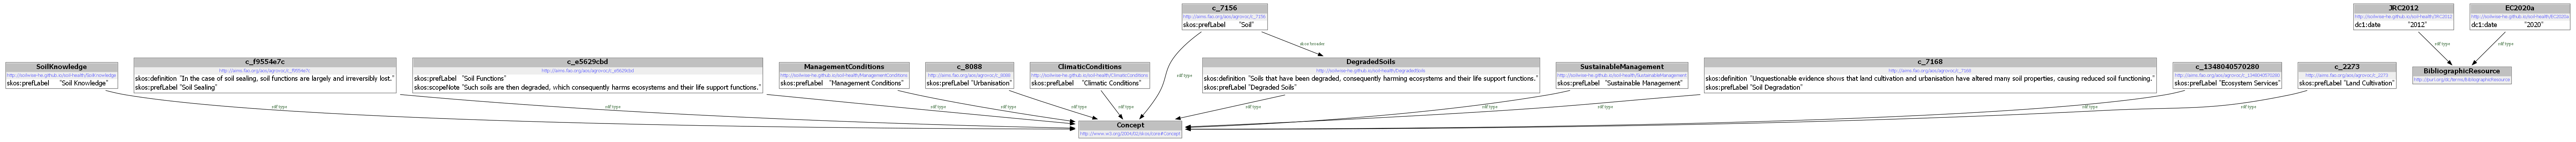

In [ ]:
visualize(g_1)

### Evaluate different strategies

In [ ]:
#Exact Match Precision, Recall and F1 
def compute_exact_match(ground_truth_triples, generated_triples):
    true_positives = set(ground_truth_triples) & set(generated_triples)
    false_positives = set(generated_triples) - set(ground_truth_triples)
    false_negatives = set(ground_truth_triples) - set(generated_triples)

    precision = len(true_positives) / len(generated_triples) if generated_triples else 0
    recall = len(true_positives) / len(ground_truth_triples) if ground_truth_triples else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1_score

In [ ]:
def compute_partial_metrics(gt_triples, gen_triples):
    # Dictionaries to count matches for subjects, predicates, and objects separately
    matched_gt_indices = {
        'subject': set(),
        'predicate': set(),
        'object': set()
    }

    # Convert triples to lists for easy access
    gt_triples_list = list(gt_triples)
    gen_triples_list = list(gen_triples)

    # Count matches for each component
    match_counts = {'subject': 0, 'predicate': 0, 'object': 0}

    # Iterate over generated triples
    for idx_gen, (gen_s, gen_p, gen_o) in enumerate(gen_triples_list):
        for idx_gt, (gt_s, gt_p, gt_o) in enumerate(gt_triples_list):
            # Check subject match independently
            if gen_s == gt_s and idx_gt not in matched_gt_indices['subject']:
                match_counts['subject'] += 1
                matched_gt_indices['subject'].add(idx_gt)
            
            # Check predicate match independently
            if gen_p == gt_p and idx_gt not in matched_gt_indices['predicate']:
                match_counts['predicate'] += 1
                matched_gt_indices['predicate'].add(idx_gt)
            
            # Check object match independently
            if gen_o == gt_o and idx_gt not in matched_gt_indices['object']:
                match_counts['object'] += 1
                matched_gt_indices['object'].add(idx_gt)

    # Total counts for generated and ground truth triples
    total_gen = len(gen_triples_list)
    total_gt = len(gt_triples_list)

    # Compute precision, recall, and F1 for each component
    def compute_metrics(matched_count, total_gen, total_gt):
        precision = matched_count / total_gen if total_gen else 0
        recall = matched_count / total_gt if total_gt else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        return precision, recall, f1_score

    subject_precision, subject_recall, subject_f1 = compute_metrics(match_counts['subject'], total_gen, total_gt)
    predicate_precision, predicate_recall, predicate_f1 = compute_metrics(match_counts['predicate'], total_gen, total_gt)
    object_precision, object_recall, object_f1 = compute_metrics(match_counts['object'], total_gen, total_gt)

    # Calculate overall metrics by summing matches across all components
    total_possible = len(gen_triples) * 3
    total_matches = match_counts['subject'] + match_counts['predicate'] + match_counts['object']
    total_gt_possible = len(gt_triples) * 3

    overall_precision = total_matches / total_possible if total_possible else 0
    overall_recall = total_matches / total_gt_possible if total_gt_possible else 0
    overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) else 0

    # Return metrics for each component and overall results
    return {
        'subject': (subject_precision, subject_recall, subject_f1),
        'predicate': (predicate_precision, predicate_recall, predicate_f1),
        'object': (object_precision, object_recall, object_f1),
        'overall': (overall_precision, overall_recall, overall_f1_score)
    }


In [ ]:
#Results of zero-shot
precision, recall, f1_score = compute_exact_match(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_0))

print(f"Precision (EM): {precision:.4f}")
print(f"Recall (EM): {recall:.4f}")
print(f"F1 Score (EM): {f1_score:.4f}")

Precision (EM): 0.1176
Recall (EM): 0.1364
F1 Score (EM): 0.1263


In [ ]:
#Results of zero-shot
results = compute_partial_metrics(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_0))

print(f"Subject - Precision: {results['subject'][0]:.4f}, Recall: {results['subject'][1]:.4f}, F1: {results['subject'][2]:.4f}")
print(f"Predicate - Precision: {results['predicate'][0]:.4f}, Recall: {results['predicate'][1]:.4f}, F1: {results['predicate'][2]:.4f}")
print(f"Object - Precision: {results['object'][0]:.4f}, Recall: {results['object'][1]:.4f}, F1: {results['object'][2]:.4f}")
print(f"Overall - Precision: {results['overall'][0]:.4f}, Recall: {results['overall'][1]:.4f}, F1: {results['overall'][2]:.4f}")

Subject - Precision: 0.3725, Recall: 0.4318, F1: 0.4000
Predicate - Precision: 0.5098, Recall: 0.5909, F1: 0.5474
Object - Precision: 0.2549, Recall: 0.2955, F1: 0.2737
Overall - Precision: 0.3791, Recall: 0.4394, F1: 0.4070


In [ ]:
#Results of prompt engineering
precision, recall, f1_score = compute_exact_match(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_p))

print(f"Precision (EM): {precision:.4f}")
print(f"Recall (EM): {recall:.4f}")
print(f"F1 Score (EM): {f1_score:.4f}")

Precision (EM): 0.1579
Recall (EM): 0.1364
F1 Score (EM): 0.1463


In [ ]:
#Results of prompt engineering
results = compute_partial_metrics(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_p))

print(f"Subject - Precision: {results['subject'][0]:.4f}, Recall: {results['subject'][1]:.4f}, F1: {results['subject'][2]:.4f}")
print(f"Predicate - Precision: {results['predicate'][0]:.4f}, Recall: {results['predicate'][1]:.4f}, F1: {results['predicate'][2]:.4f}")
print(f"Object - Precision: {results['object'][0]:.4f}, Recall: {results['object'][1]:.4f}, F1: {results['object'][2]:.4f}")
print(f"Overall - Precision: {results['overall'][0]:.4f}, Recall: {results['overall'][1]:.4f}, F1: {results['overall'][2]:.4f}")

Subject - Precision: 0.6316, Recall: 0.5455, F1: 0.5854
Predicate - Precision: 0.6842, Recall: 0.5909, F1: 0.6341
Object - Precision: 0.3158, Recall: 0.2727, F1: 0.2927
Overall - Precision: 0.5439, Recall: 0.4697, F1: 0.5041


In [ ]:
#Results of one-shot
precision, recall, f1_score = compute_exact_match(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_1))

print(f"Precision (EM): {precision:.4f}")
print(f"Recall (EM): {recall:.4f}")
print(f"F1 Score (EM): {f1_score:.4f}")

Precision (EM): 0.4242
Recall (EM): 0.3182
F1 Score (EM): 0.3636


In [ ]:
#Results of one-shot
results = compute_partial_metrics(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_1))

print(f"Subject - Precision: {results['subject'][0]:.4f}, Recall: {results['subject'][1]:.4f}, F1: {results['subject'][2]:.4f}")
print(f"Predicate - Precision: {results['predicate'][0]:.4f}, Recall: {results['predicate'][1]:.4f}, F1: {results['predicate'][2]:.4f}")
print(f"Object - Precision: {results['object'][0]:.4f}, Recall: {results['object'][1]:.4f}, F1: {results['object'][2]:.4f}")
print(f"Overall - Precision: {results['overall'][0]:.4f}, Recall: {results['overall'][1]:.4f}, F1: {results['overall'][2]:.4f}")

Subject - Precision: 0.6364, Recall: 0.4773, F1: 0.5455
Predicate - Precision: 0.8788, Recall: 0.6591, F1: 0.7532
Object - Precision: 0.6667, Recall: 0.5000, F1: 0.5714
Overall - Precision: 0.7273, Recall: 0.5455, F1: 0.6234


### Post-process the knowledge graph

In [ ]:
def parse_turtle(turtle_string):
    g = Graph()
    g.parse(data=turtle_string, format='turtle')
    return g

def merge_graphs(json_data):
    merged_graph = Graph()
    
    for item in json_data['dataset']:
        turtle_string = item['rdf_graph_turtle']
        graph = parse_turtle(turtle_string)
        merged_graph += graph
    
    return merged_graph

def remove_duplicates(graph):
    # Create a new graph to store unique triples
    unique_graph = Graph()
    
    # Iterate through all triples in the original graph
    for s, p, o in graph:
        # Check if the triple already exists in the unique graph
        if not (s, p, o) in unique_graph:
            unique_graph.add((s, p, o))
    
    return unique_graph

def main(file_path):
    merged_graph = merge_graphs(data)
    unique_graph = remove_duplicates(merged_graph)

    unique_graph.bind("agrovoc", agrovoc)
    unique_graph.bind("glosis_lh", glosis_lh)
    unique_graph.bind("ns0", NS0)

    # Serialize the final graph to Turtle format
    output_file = "soil_health_KG.ttl"
    unique_graph.serialize(destination=output_file, format="turtle")

if __name__ == "__main__":
    file_path = "text_RDF_gt.json"
    main(file_path)

### Interlink to external databases: a Zenodo example

In [ ]:
# Define the API endpoint URL
api_url = "https://zenodo.org/api/records"

# query for datasources with 'soil'
# get first 200 datasources
# loop through pages to retrieve next part of data
# only get sources with status published
# options: https://developers.zenodo.org/?python#list36

# list to gather all data through API requests
zenodo_data = []

# loop through pages to retreive next part of data
for i in range(1,11):
    print(f'loop num {i}')
    params = {'q': 'soil',
              'size':'20',
              'page':f'{i}',
              'status':'published',
              'sort':'bestmatch',
              'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url,params = params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        zenodo_data = zenodo_data + data['hits']['hits']
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
zenodo_data

loop num 1
loop num 2
loop num 3
loop num 4
loop num 5
loop num 6
loop num 7
loop num 8
loop num 9
loop num 10


[{'created': '2021-08-05T16:06:00.842433+00:00',
  'modified': '2021-08-06T01:48:27.870247+00:00',
  'id': 5159133,
  'conceptrecid': '5159132',
  'doi': '10.5281/zenodo.5159133',
  'conceptdoi': '10.5281/zenodo.5159132',
  'doi_url': 'https://doi.org/10.5281/zenodo.5159133',
  'metadata': {'title': 'Soil Survey of Scotland Staff (1970-1987). Soil maps of Scotland (partial coverage) at a scale of 1:25 000. Digital phase 8 release.',
   'doi': '10.5281/zenodo.5159133',
   'publication_date': '2021-08-04',
   'description': '<p>This is the digital dataset which was created by digitising the Soils of Scotland 1:25,000 Soil maps and the Soils of Scotland 1:25,000 Dyeline Masters. The Soils of Scotland 1:25,000 Soil maps were the source documents for the production of the Soils of Scotland 1:63,360 and 1:50,000 published map series. Where no 1:25,000 published maps exist 1:63,360 maps have been digitised for this data set, the field SOURCE_MAP describes the source of the data. The classific

In [ ]:
# gather the id's in list to then extract data directly as dublincore representation
id_list = []
for i in range(0,len(zenodo_data)):
    id_list.append(zenodo_data[i]['id'])

In [ ]:
# Convert HTML to plain text
class CleanHTML(HTMLParser):
    def reset(self) -> None:
        self.extracted_data = ""
        return super().reset()

    def remove_tags(self, html_data: str) -> str:
        """
        Args:
            html_data (str): HTML data which might contain tags.

        Returns:
            str: Data without any HTML tags. Forces feeding of any buffered data.
        """
        self.reset()
        self.feed(html_data)
        self.close()
        return self.extracted_data

    def handle_data(self, data: str) -> None:
        """
        Args:
            data (str): Html data extracted from tags to be processed.
        """
        self.extracted_data += data

p = CleanHTML()

In [ ]:
# Extract DublinCore standardized metadata and generate json with all data
zenodo_dc_data = {}
for i in range(len(id_list)):

    # Define the API endpoint URL
    api_url = f"https://zenodo.org/records/{id_list[i]}/export/dublincore"
    params = {'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url, params = params, headers=headers, timeout=None)

    # Check if the request was successful
    if response.status_code == 200:
        try:
            # Parse the XML response
            root = ET.fromstring(response.content)

            # Define expected tags with namespace
            expected_tags = {
                "{http://purl.org/dc/elements/1.1/}creator": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}subject": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}date": None,         # Initialize as None
                "{http://purl.org/dc/elements/1.1/}title": None,        # Initialize as None
                "{http://purl.org/dc/elements/1.1/}description": None,   # Initialize as None
                "{http://purl.org/dc/elements/1.1/}identifier": None,    # Initialize as None
                "{http://purl.org/dc/elements/1.1/}language": None    # Initialize as None
            }

            # Create a dictionary for JSON conversion
            json_dict = {}

            # Check if the root has child elements
            if root:
                for child in root:
                    # Get full tag name, preserving namespace
                    tag = child.tag
                    text = p.remove_tags(unescape(child.text))  # Convert HTML entities to normal text

                    if tag in expected_tags:
                        if "creator" in tag or "subject" in tag:
                            if "creator" in tag:
                                if json_dict.get(tag) is None:
                                    json_dict[tag] = [text]
                                else:
                                    json_dict[tag].append(text)
                            elif "subject" in tag:
                                # Split subjects and strip spaces                              
                                subjects = [subj.strip() for subj in re.split(r'[;,]', text)]
                                if json_dict.get(tag) is None:                                  
                                    json_dict[tag] = subjects
                                else:
                                    json_dict[tag].extend(subjects)
                        else:
                            if json_dict.get(tag) is None:
                                json_dict[tag] = text  # Directly store as a string for date, title, description and identifier

                # Ensure all expected tags are included in the json_dict
                for tag, value in expected_tags.items():
                    if tag not in json_dict:
                        json_dict[tag] = value

                output_dict = {}
                # Adjusting the output to match the "dc:" prefix requirement
                for key, value in json_dict.items():
                    adjusted_key = key.split('}')[-1]  # Remove namespace URI
                    output_dict["dc:" + adjusted_key] = value

                zenodo_dict={
                    i:output_dict
                }
                
                #add to general json
                zenodo_dc_data.update(zenodo_dict)
            
            else:
                print("No repositories found in the response.")
        except ET.ParseError:
            print("Error: Unable to parse XML content.")
    else:
        # Print an error message if the request was not successful
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        print(response.text)

In [ ]:
# Convert metadata to RDF statements
# Dictionary of metadata entries, indexed by a unique key
metadata_entries = zenodo_dc_data

# Fill in all the missing keywords under named graph "generated"
# Create a ConjunctiveGraph to store quads
g_zenodo_extend = ConjunctiveGraph()

# Define named graphs
metadata_graph = URIRef("http://soilwise-he.github.io/soil-health/metadata")
generated_graph = URIRef("http://soilwise-he.github.io/soil-health/augmented")

# keywords generation
def generate_subjects(text):
    # Placeholder function to simulate generating subjects based on the title
    kw_model = KeyBERT()
    seed_keywords = ["soil"]

    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words=None, seed_keywords=seed_keywords, use_mmr=True, diversity=0.5)
    keywords = [item[0] for item in keywords if item[1] > 0.5]
    
    return keywords

# Loop through each metadata entry
for entry_id, metadata in metadata_entries.items():
    if metadata['dc:language'] is None or metadata['dc:language'] == 'eng': 
        # Define the URI for the resource using its identifier
        resource_uri = URIRef(metadata['dc:identifier'])

        # Define the resource as a BibliographicResource
        g_zenodo_extend.add((resource_uri, RDF.type, DCTERMS.BibliographicResource, metadata_graph))
    
        # Add the title, date, and identifier
        g_zenodo_extend.add((resource_uri, DCTERMS.title, Literal(metadata['dc:title']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.date, Literal(metadata['dc:date']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.identifier, URIRef(metadata['dc:identifier']), metadata_graph))

        # Add creators, which can have multiple values
        for creator in metadata['dc:creator']:
            g_zenodo_extend.add((resource_uri, DCTERMS.creator, Literal(creator), metadata_graph))
    
        # Check if subjects are provided, otherwise generate them
        if metadata['dc:subject'] is None:
            generated_subjects = generate_subjects(f"{metadata['dc:title']}. {metadata['dc:description']}")
            for subject in generated_subjects:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject), generated_graph))
        else:
            for subject in metadata['dc:subject']:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject.strip()), metadata_graph))

# Output the graph in Turtle format
g_zenodo_extend.bind("ns0", NS0)

print(g_zenodo_extend.serialize(format="trig"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .

ns0:augmented {
    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.xpnvx0kh2> dcterms:subject "soil biochar",
            "soil organic" .

    <https://doi.org/10.5281/zenodo.10401745> dcterms:subject "soil hydraulic",
            "soil properties" .

    <https://doi.org/10.5281/zenodo.10605462> dcterms:subject "soil arthropods",
            "soil quality",
            "soildwelling insects" .

    <https://doi.org/10.5281/zenodo.1065954> dcterms:subject "rainfall mapping" .

    <https://doi.org/10.5281/zenodo.11399291> dcterms:subject "expansive soil",
            "soil lime",
     

In [ ]:
# Interlink metadata quads with soil health knowledge graph
# Function to link concepts
def link_concepts(graph, concept_graph):
    # Extract all concept URIs and labels
    labels = {}
    for c in concept_graph.subjects(RDF.type, SKOS.Concept):
        pref_label = concept_graph.value(c, SKOS.prefLabel)
        labels[c] = [pref_label.lower() if pref_label else ""]

    for s, p, o, g in graph.quads((None, None, None, None)):
        subject_label = o.lower()
        for c, label_list in labels.items():
            if subject_label in label_list:
                graph.remove((s, p, o, g))
                graph.add((s, p, c, g))  # Preserve original predicate
                concept_graph.add((c, DCTERMS.source, s))

# Link concepts between metadata and concept graphs
link_concepts(g_zenodo_extend, unique_graph)

# Serialize the graphs to check the output
print("Concept Graph:")
print(unique_graph.serialize(format='turtle'))

Concept Graph:
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix glosis_lh: <http://w3id.org/glosis/model/layerhorizon/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix ns1: <http://aims.fao.org/aos/agrontology#> .
@prefix ns2: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

agrovoc:c_1348040570280 a skos:Concept ;
    ns1:isInfluencedBy ns0:SoilHealth ;
    ns1:makeUseOf agrovoc:c_e5629cbd ;
    skos:prefLabel "Ecosystem Services" .

agrovoc:c_2482 a skos:Concept ;
    ns1:isAffectedBy agrovoc:c_7168 ;
    skos:prefLabel "Ecosystems" .

agrovoc:c_25398 a skos:Concept ;
    ns1:benefitsFrom agrovoc:c_a9645d28,
        ns0:SoilHealth ;
    skos:prefLabel "Plant Health" .

agrovoc:c_330883 a skos:Concept ;
    ns1:isAffectedBy agrovoc:c_8088,
        ns0:LandCulti

In [ ]:
g_zenodo_extend.bind("agrovoc", agrovoc)
g_zenodo_extend.bind("ns0", NS0)

print("Metadata Graph:")
print(g_zenodo_extend.serialize(format='trig'))

Metadata Graph:
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .

ns0:augmented {
    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.xpnvx0kh2> dcterms:subject "soil biochar",
            "soil organic" .

    <https://doi.org/10.5281/zenodo.10401745> dcterms:subject agrovoc:c_330883,
            "soil hydraulic" .

    <https://doi.org/10.5281/zenodo.10605462> dcterms:subject agrovoc:c_a9645d28,
            "soil arthropods",
            "soildwelling insects" .

    <https://doi.org/10.5281/zenodo.1065954> dcterms:subject "rainfall mapping" .

    <https://doi.org/10.5281/zenodo.1

In [ ]:
concept_graph_extended = ConjunctiveGraph()

for triple in unique_graph:
    concept_graph_extended.add(triple)

for quad in g_zenodo_extend.quads((None, None, None, None)):
    concept_graph_extended.add(quad)

concept_graph_extended.bind("agrovoc", agrovoc)
concept_graph_extended.bind("ns0", NS0)
concept_graph_extended.bind("glosis_lh", glosis_lh)

print(concept_graph_extended.serialize(format='trig'))
# Save the graph to a file
concept_graph_extended.serialize(destination="example_SWR.trig", format="trig")

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix glosis_lh: <http://w3id.org/glosis/model/layerhorizon/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix ns1: <http://aims.fao.org/aos/agrontology#> .
@prefix ns2: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ns0:augmented {
    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.xpnvx0kh2> dcterms:subject "soil biochar",
            "soil organic" .

    <https://doi.org/10.5281/zenodo.10401745> dcterms:subject agrovoc:c

<Graph identifier=N55f1989c0eaa475a81cbe23ead6d0272 (<class 'rdflib.graph.ConjunctiveGraph'>)>

### Validate the (extended) knowledge graph by question answering (with NLQ)

In [ ]:
graph = RdfGraph(
    source_file="example_SWR.trig",
    serialization="trig",
)

In [ ]:
llm = ChatOpenAI(model="chatgpt-4o-latest", temperature=0)
chain = GraphSparqlQAChain.from_llm(llm=llm, graph=graph, return_sparql_query=True, verbose=True)

In [ ]:
print(graph.get_schema)

In the following, each IRI is followed by the local name and optionally its description in parentheses. 
The RDF graph supports the following node types:
<http://purl.org/dc/terms/BibliographicResource> (BibliographicResource, None), <http://www.w3.org/2004/02/skos/core#Concept> (Concept, None), <http://qudt.org/schema/qudt/QuantityValue> (QuantityValue, None)
The RDF graph supports the following relationships:
<http://purl.org/dc/terms/source> (source, None), <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> (type, None), <http://www.w3.org/2004/02/skos/core#exactMatch> (exactMatch, None), <http://www.w3.org/2004/02/skos/core#scopeNote> (scopeNote, None), <http://www.w3.org/2000/01/rdf-schema#label> (label, None), <http://aims.fao.org/aos/agrontology#isAffectedBy> (isAffectedBy, None), <http://www.w3.org/2004/02/skos/core#prefLabel> (prefLabel, None), <http://www.w3.org/2004/02/skos/core#definition> (definition, None), <http://www.w3.org/2004/02/skos/core#closeMatch> (closeMatch, None

In [ ]:
result = chain.invoke("""
    what is the difference between soil health and soil quality?

    Please only generate the pure SPARQL query without any quote and '```';
    Note that the difference between concepts is expressed by "skos:scopeNote";
    Please generate case insensitive SPARQL query for string match, thank you!
""")

print(f"Final answer: {result['result']}")



> Entering new GraphSparqlQAChain chain...
Identified intent:
SELECT
Generated SPARQL:
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?scopeNote1 ?scopeNote2
WHERE {
    ?concept1 skos:prefLabel ?label1 .
    ?concept2 skos:prefLabel ?label2 .
    FILTER (lcase(?label1) = "soil health" && lcase(?label2) = "soil quality") .
    ?concept1 skos:scopeNote ?scopeNote1 .
    ?concept2 skos:scopeNote ?scopeNote2 .
}
Full Context:
[(rdflib.term.Literal('The actual capacity of a soil to perform its core functions and to provide ecosystem services.'), rdflib.term.Literal('The inherent capacity which provides the basic frame within which a soil evolves.'))]

> Finished chain.
Final answer: SELECT ?definition1 ?definition2
WHERE {
  ?concept1 skos:scopeNote ?definition1 .
  ?concept2 skos:scopeNote ?definition2 .
  FILTER (lcase(str(?definition1)) = lcase(str("soil health")) || lcase(str(?definition2)) = lcase(str("soil quality")))
}


In [ ]:
query = result['sparql_query']

# Execute the query
for row in graph.query(query):
    print(f"{row.scopeNote1}\n{row.scopeNote2}")

The actual capacity of a soil to perform its core functions and to provide ecosystem services.
The inherent capacity which provides the basic frame within which a soil evolves.


In [ ]:
with open('benchmarks/q_SPARQL_a.json', 'r') as f:
    qa = json.load(f)

qa_pair = qa['qa_pairs'][0]
query = qa_pair['sparql_query']

for row in graph.query(query):
    print(f"Soil health: {row.SoilHealth}\nSoil quality: {row.SoilQuality}")

Soil health: The actual capacity of a soil to perform its core functions and to provide ecosystem services.
Soil quality: The inherent capacity which provides the basic frame within which a soil evolves.
